In [1]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cftime
import cartopy
import cartopy.crs as ccrs
import scipy.stats as stats
from scipy.io import loadmat

import string
alphabet=list(string.ascii_lowercase)

import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Read in Files

In [3]:
cases=['gzCOBALT-013022','gzCOBALT-tun','gzCOBALT-hp','gzCOBALT-tun_hp']

In [4]:
files={}
for case in cases:
    prefix=case
    if case == 'gzCOBALT-tun':
        prefix='gzCOBALT-tun_c'
    files[case]=sorted(glob('data/hypoxicVolume.'+prefix+'*.nc'))
    
files

{'gzCOBALT-013022': ['data/hypoxicVolume.gzCOBALT-013022.nc',
  'data/hypoxicVolume.gzCOBALT-013022_cy2.nc',
  'data/hypoxicVolume.gzCOBALT-013022_cy3.nc',
  'data/hypoxicVolume.gzCOBALT-013022_cy4.nc',
  'data/hypoxicVolume.gzCOBALT-013022_cy5.nc'],
 'gzCOBALT-tun': ['data/hypoxicVolume.gzCOBALT-tun_cy1.nc',
  'data/hypoxicVolume.gzCOBALT-tun_cy2.nc',
  'data/hypoxicVolume.gzCOBALT-tun_cy3.nc',
  'data/hypoxicVolume.gzCOBALT-tun_cy4.nc',
  'data/hypoxicVolume.gzCOBALT-tun_cy5.nc'],
 'gzCOBALT-hp': ['data/hypoxicVolume.gzCOBALT-hp_cy1.nc',
  'data/hypoxicVolume.gzCOBALT-hp_cy2.nc',
  'data/hypoxicVolume.gzCOBALT-hp_cy3.nc',
  'data/hypoxicVolume.gzCOBALT-hp_cy4.nc',
  'data/hypoxicVolume.gzCOBALT-hp_cy5.nc'],
 'gzCOBALT-tun_hp': ['data/hypoxicVolume.gzCOBALT-tun_hp_cy1.nc',
  'data/hypoxicVolume.gzCOBALT-tun_hp_cy2.nc',
  'data/hypoxicVolume.gzCOBALT-tun_hp_cy3.nc',
  'data/hypoxicVolume.gzCOBALT-tun_hp_cy4.nc',
  'data/hypoxicVolume.gzCOBALT-tun_hp_cy5.nc']}

In [5]:
# read xarray datasets into a dictionary
ds_list={}
for case in cases:
    filenames=files[case]
    ds_list[case]=xr.open_mfdataset(filenames, combine='by_coords')
    ds_list[case]=ds_list[case].rename_vars(name_dict={'sub_60mmol':case+'_sub_60mmol',
                                                      'sub_5mmol':case+'_sub_5mmol'})

In [6]:
# pull into one
ds = xr.combine_by_coords([ds_list['gzCOBALT-013022'],
                           ds_list['gzCOBALT-tun'],
                           ds_list['gzCOBALT-hp'],
                           ds_list['gzCOBALT-tun_hp']])
ds

<xarray.Dataset>
Dimensions:                     (time: 300)
Coordinates:
  * time                        (time) int64 1 2 3 4 5 6 ... 296 297 298 299 300
Data variables:
    gzCOBALT-013022_sub_60mmol  (time) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    gzCOBALT-013022_sub_5mmol   (time) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    gzCOBALT-hp_sub_60mmol      (time) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    gzCOBALT-hp_sub_5mmol       (time) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    gzCOBALT-tun_hp_sub_60mmol  (time) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    gzCOBALT-tun_hp_sub_5mmol   (time) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    gzCOBALT-tun_sub_60mmol     (time) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    gzCOBALT-tun_sub_5mmol      (time) float32 dask.array<chunksize=(60,), meta=np.ndarray>

# Plot

In [7]:
colors=['#000000', '#05A8AA', '#D7B49E', '#BC412B']

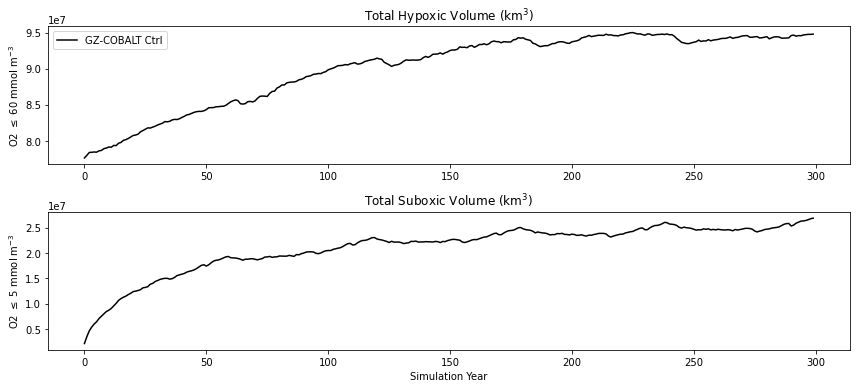

In [8]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,5.5))
fig.subplots_adjust(hspace=0.5)

# hypoxic
field1a = ds['gzCOBALT-013022_sub_60mmol'] / 1e9
field1b = ds['gzCOBALT-tun_sub_60mmol'] / 1e9
#field1c = ds['gzCOBALT-hp_sub_60mmol'] / 1e9
#field1d = ds['gzCOBALT-tun_hp_sub_60mmol'] / 1e9

ax1.plot(field1a.values, c=colors[0])
#ax1.plot(field1b.values, c=colors[1])
#ax1.plot(field1c.values, c=colors[2])
#ax1.plot(field1d.values, c=colors[3])

ax1.legend(['GZ-COBALT Ctrl','Tunicate fast POC','Fish fast POC', 'Tunicate & Fish fast POC'])
ax1.set_title('Total Hypoxic Volume (km$^{3}$)')
ax1.set_ylabel('O2 $\leq$ 60 mmol m$^{-3}$')

# suboxic
field2a = ds['gzCOBALT-013022_sub_5mmol'] / 1e9
#field2b = ds['gzCOBALT-tun_sub_5mmol'] / 1e9
#field2c = ds['gzCOBALT-hp_sub_5mmol'] / 1e9
#field2d = ds['gzCOBALT-tun_hp_sub_5mmol'] / 1e9

ax2.plot(field2a.values, c=colors[0])
#ax2.plot(field2b.values, c=colors[1])
#ax2.plot(field2c.values, c=colors[2])
#ax2.plot(field2d.values, c=colors[3])

ax2.set_ylabel('O2 $\leq$ 5 mmol m$^{-3}$')
ax2.set_xlabel('Simulation Year')
ax2.set_title('Total Suboxic Volume (km$^{3}$)')

plt.tight_layout()
plt.savefig('plots/Hypoxic_Suboxic_Volume_ts_01.png', dpi=300, bbox_inches='tight')

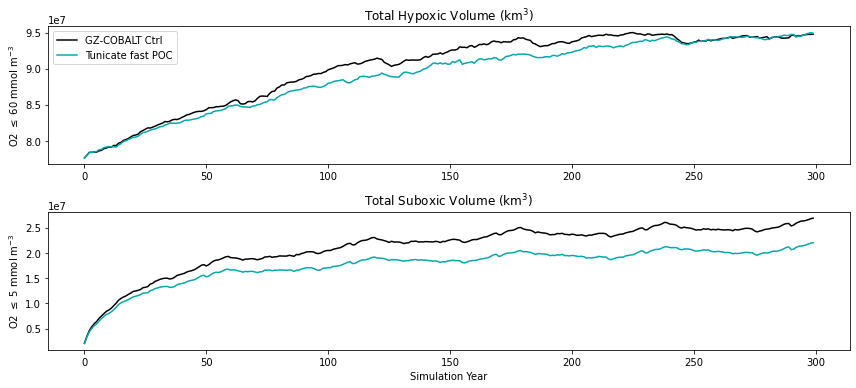

In [9]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,5.5))
fig.subplots_adjust(hspace=0.5)

# hypoxic
field1a = ds['gzCOBALT-013022_sub_60mmol'] / 1e9
field1b = ds['gzCOBALT-tun_sub_60mmol'] / 1e9
#field1c = ds['gzCOBALT-hp_sub_60mmol'] / 1e9
#field1d = ds['gzCOBALT-tun_hp_sub_60mmol'] / 1e9

ax1.plot(field1a.values, c=colors[0])
ax1.plot(field1b.values, c=colors[1])
#ax1.plot(field1c.values, c=colors[2])
#ax1.plot(field1d.values, c=colors[3])

ax1.legend(['GZ-COBALT Ctrl','Tunicate fast POC','Fish fast POC', 'Tunicate & Fish fast POC'])
ax1.set_title('Total Hypoxic Volume (km$^{3}$)')
ax1.set_ylabel('O2 $\leq$ 60 mmol m$^{-3}$')

# suboxic
field2a = ds['gzCOBALT-013022_sub_5mmol'] / 1e9
field2b = ds['gzCOBALT-tun_sub_5mmol'] / 1e9
#field2c = ds['gzCOBALT-hp_sub_5mmol'] / 1e9
#field2d = ds['gzCOBALT-tun_hp_sub_5mmol'] / 1e9

ax2.plot(field2a.values, c=colors[0])
ax2.plot(field2b.values, c=colors[1])
#ax2.plot(field2c.values, c=colors[2])
#ax2.plot(field2d.values, c=colors[3])

ax2.set_ylabel('O2 $\leq$ 5 mmol m$^{-3}$')
ax2.set_xlabel('Simulation Year')
ax2.set_title('Total Suboxic Volume (km$^{3}$)')

plt.tight_layout()
plt.savefig('plots/Hypoxic_Suboxic_Volume_ts_02.png', dpi=300, bbox_inches='tight')

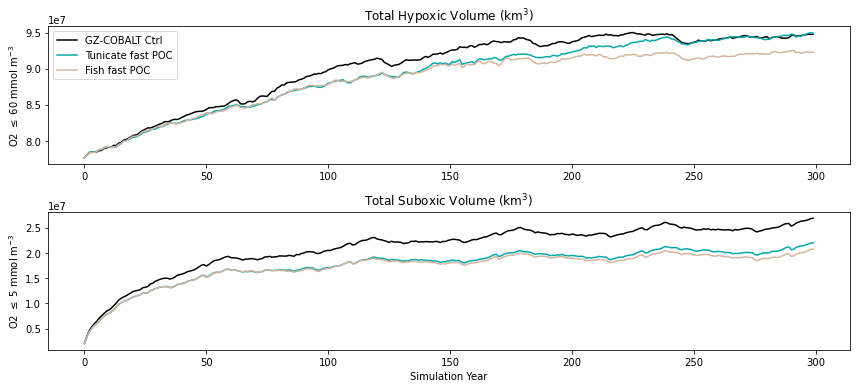

In [10]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,5.5))
fig.subplots_adjust(hspace=0.5)

# hypoxic
field1a = ds['gzCOBALT-013022_sub_60mmol'] / 1e9
field1b = ds['gzCOBALT-tun_sub_60mmol'] / 1e9
field1c = ds['gzCOBALT-hp_sub_60mmol'] / 1e9
#field1d = ds['gzCOBALT-tun_hp_sub_60mmol'] / 1e9

ax1.plot(field1a.values, c=colors[0])
ax1.plot(field1b.values, c=colors[1])
ax1.plot(field1c.values, c=colors[2])
#ax1.plot(field1d.values, c=colors[3])

ax1.legend(['GZ-COBALT Ctrl','Tunicate fast POC','Fish fast POC', 'Tunicate & Fish fast POC'])
ax1.set_title('Total Hypoxic Volume (km$^{3}$)')
ax1.set_ylabel('O2 $\leq$ 60 mmol m$^{-3}$')

# suboxic
field2a = ds['gzCOBALT-013022_sub_5mmol'] / 1e9
field2b = ds['gzCOBALT-tun_sub_5mmol'] / 1e9
field2c = ds['gzCOBALT-hp_sub_5mmol'] / 1e9
#field2d = ds['gzCOBALT-tun_hp_sub_5mmol'] / 1e9

ax2.plot(field2a.values, c=colors[0])
ax2.plot(field2b.values, c=colors[1])
ax2.plot(field2c.values, c=colors[2])
#ax2.plot(field2d.values, c=colors[3])

ax2.set_ylabel('O2 $\leq$ 5 mmol m$^{-3}$')
ax2.set_xlabel('Simulation Year')
ax2.set_title('Total Suboxic Volume (km$^{3}$)')

plt.tight_layout()
plt.savefig('plots/Hypoxic_Suboxic_Volume_ts_03.png', dpi=300, bbox_inches='tight')

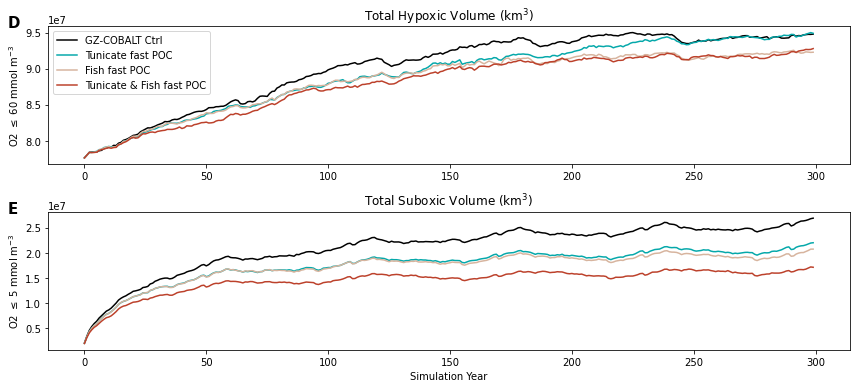

In [11]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,5.5))
fig.subplots_adjust(hspace=0.5)

# hypoxic
field1a = ds['gzCOBALT-013022_sub_60mmol'] / 1e9
field1b = ds['gzCOBALT-tun_sub_60mmol'] / 1e9
field1c = ds['gzCOBALT-hp_sub_60mmol'] / 1e9
field1d = ds['gzCOBALT-tun_hp_sub_60mmol'] / 1e9

ax1.plot(field1a.values, c=colors[0])
ax1.plot(field1b.values, c=colors[1])
ax1.plot(field1c.values, c=colors[2])
ax1.plot(field1d.values, c=colors[3])

ax1.text(-0.05, 1.08, 'D', transform=ax1.transAxes, fontsize=15, fontweight='bold', va='top')

ax1.legend(['GZ-COBALT Ctrl','Tunicate fast POC','Fish fast POC', 'Tunicate & Fish fast POC'])
ax1.set_title('Total Hypoxic Volume (km$^{3}$)')
ax1.set_ylabel('O2 $\leq$ 60 mmol m$^{-3}$')

# suboxic
field2a = ds['gzCOBALT-013022_sub_5mmol'] / 1e9
field2b = ds['gzCOBALT-tun_sub_5mmol'] / 1e9
field2c = ds['gzCOBALT-hp_sub_5mmol'] / 1e9
field2d = ds['gzCOBALT-tun_hp_sub_5mmol'] / 1e9

ax2.plot(field2a.values, c=colors[0])
ax2.plot(field2b.values, c=colors[1])
ax2.plot(field2c.values, c=colors[2])
ax2.plot(field2d.values, c=colors[3])

ax2.text(-0.05, 1.08, 'E', transform=ax2.transAxes, fontsize=15, fontweight='bold', va='top')

ax2.set_ylabel('O2 $\leq$ 5 mmol m$^{-3}$')
ax2.set_xlabel('Simulation Year')
ax2.set_title('Total Suboxic Volume (km$^{3}$)')

plt.tight_layout()
plt.savefig('plots/Hypoxic_Suboxic_Volume_ts_all.png', dpi=350, bbox_inches='tight')

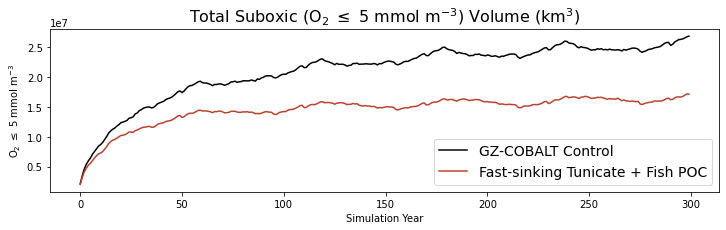

In [12]:
fig,ax2 = plt.subplots(1,1, figsize=(12,3))
fig.subplots_adjust(hspace=0.5)

# suboxic
field2a = ds['gzCOBALT-013022_sub_5mmol'] / 1e9
field2d = ds['gzCOBALT-tun_hp_sub_5mmol'] / 1e9

ax2.plot(field2a.values,c=colors[0])
ax2.plot(field2d.values,c=colors[3])

ax2.legend(['GZ-COBALT Control', 'Fast-sinking Tunicate + Fish POC'],fontsize=14)
ax2.set_ylabel('O$_2$ $\leq$ 5 mmol m$^{-3}$')
ax2.set_xlabel('Simulation Year')
ax2.set_title('Total Suboxic (O$_2$ $\leq$ 5 mmol m$^{-3}$) Volume (km$^{3}$)', fontsize=16)

plt.savefig('plots/Suboxic_Volume_ts_extremes.png', dpi=300, bbox_inches='tight')